In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)
import os
root_path = 'gdrive/My Drive/EACL/'
os.chdir(root_path)

Mounted at /content/gdrive


In [ ]:
!pip install sentencepiece==0.1.94
!pip install transformers==4.0.1
!pip install demoji
!pip install tweet-preprocessor
# !pip install transformers[sentencepiece]

     |████████████████████████████████| 1.1MB 16.2MB/s 
     |████████████████████████████████| 1.4MB 8.8MB/s 
     |████████████████████████████████| 890kB 45.5MB/s 
     |████████████████████████████████| 2.9MB 47.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=e959399c4de3a5d4802a074acdcedecdd9d57c57d0a5ca3bef255389ec49808e
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import numpy as np
import pandas as pd
from transformers import AutoModel, AutoTokenizer
import torch.nn as nn
import torch
import copy
from transformers import BertModel, RobertaModel, BertTokenizer, RobertaTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler, random_split, DataLoader, IterableDataset, ConcatDataset
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score 
from tqdm import tqdm
import demoji 
import random
demoji.download_codes() 
import preprocessor as p
p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.RESERVED)
plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams.update({'font.size': 8})
RANDOM_SEED = 42
model_path = 'bert-base-multilingual-cased'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

... OK (Got response in 0.13 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK


In [ ]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value)  
    torch.manual_seed(seed_value)  
    random.seed(seed_value)
    if use_cuda:
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)  
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
random_seed(RANDOM_SEED, True)

In [ ]:
class Dataset():
    def __init__(self, train_data, val_data, batch_size = 32):
        self.train_data = train_data
        self.val_data = val_data
        self.batch_size = batch_size

        self.label_dict = {'Not_offensive': 0,
                            'Offensive_Targeted_Insult_Group': 4,
                            'Offensive_Targeted_Insult_Individual': 3,
                            'Offensive_Targeted_Insult_Other': 2,
                            'Offensive_Untargetede': 1,
                            'not-Kannada': 5}
                                    
        self.count_dic = {}

        self.train_inputs, self.train_labels = self.process_data(self.train_data)
        self.val_inputs, self.val_labels = self.process_data(self.val_data)
        # count_dic = {}
        # for data in self.train_labels:
        #     label = int(data)
        #     count_dic[label] = count_dic.get(label, 0)+1
        # self.weights = torch.Tensor([len(self.train_labels)/count_dic[i] for i in range(2)]).to(device)
        self.train_dataloader = self.get_dataloader(self.train_inputs, self.train_labels)
        self.val_dataloader = self.get_dataloader(self.val_inputs, self. val_labels, train = False)

    def tokenize(self, sentences, padding = True, max_len = 256):
        tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)
        input_ids, attention_masks = [], []
        for sent in sentences:
            encoded_dict = tokenizer.encode_plus(sent,
                                                    add_special_tokens=True,
                                                    max_length=max_len, 
                                                    padding='max_length', 
                                                    return_attention_mask = True,
                                                    return_tensors = 'pt', 
                                                    truncation = True)
            input_ids.append(encoded_dict['input_ids'])
            attention_masks.append(encoded_dict['attention_mask'])
        
        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)

        return {'input_ids': input_ids, 'attention_masks': attention_masks}
    
    def process_data(self, data):
        sentences, labels = [], []
        print(len(data))
        for line in data:
            sentence = line.strip().split('\t')
            label = sentence.pop()
            # if label == 'not-Kannada': print(sentence)
            if label not in self.label_dict:
                self.label_dict[label] = len(self.label_dict)
            sentence = p.clean(' '.join(sentence)).replace('#','')
            emoji_dict = demoji.findall(sentence)
            if len(emoji_dict): 
                for emoji, text in emoji_dict.items():
                    sentence = sentence.replace(emoji, ' '+text+' ')
                    sentence = ' '.join(sentence.split())
            sentences.append(sentence)
            labels.append(self.label_dict[label])
            # if label == 'not-malayalam': labels.append(1)
            # else: labels.append(0)
            self.count_dic[labels[-1]] = self.count_dic.get(labels[-1], 0) + 1
        inputs = self.tokenize(sentences)

        return inputs, torch.Tensor(labels)
    
    def get_dataloader(self, inputs, labels, train = True):
        data = TensorDataset(inputs['input_ids'], inputs['attention_masks'], labels)
        if train:
            sampler = RandomSampler(data)
        else:
            sampler = SequentialSampler(data)
        return DataLoader(data, sampler=sampler, batch_size=self.batch_size)

In [ ]:
with open('Dataset/kannada_offensive_train.csv', 'r') as f:
    train_data = f.readlines()
with open('Dataset/kannada_offensive_dev.csv', 'r') as f:
    val_data = f.readlines()
data = Dataset(train_data, val_data)

6217
777


In [ ]:
data.count_dic

{0: 3970, 1: 245, 2: 139, 3: 553, 4: 374, 5: 1713}

In [ ]:
# Save and Load Functions
def save_metrics(save_path, epochs, model, optimizer, F1):

    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'epochs': epochs+1,
                  'F1': F1}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path, model, optimizer):
    try: 
        state_dict = torch.load(load_path, map_location=device)
        model.load_state_dict(state_dict['model_state_dict'])
        optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    except: 
        state_dict = {}

    print(f'Model loaded from <== {load_path}')
    
    return state_dict.get('epochs', 0), state_dict.get('F1', 0)

In [ ]:
class Transform(torch.nn.Module):
    def __init__(self, D_in, num_labels):
        super(Transform, self).__init__()
        self.embeddings = AutoModel.from_pretrained(model_path)
        self.dropout = nn.Dropout(0.3)
        self.final = nn.Linear(D_in*2, num_labels, bias = True)

    def forward(self, input_ids, mask):
        outputs = self.embeddings(input_ids, mask)
        out = outputs.last_hidden_state
        mean_pooling = torch.mean(out, 1)
        max_pooling, _ = torch.max(out, 1)

        embed = torch.cat((mean_pooling, max_pooling), 1)
        y_pred = self.final(self.dropout(embed))
        return y_pred

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
 
def get_predicted(preds):
    pred_flat = np.argmax(preds, axis=1).flatten()
    return pred_flat
 
def evaluate(test_dataloader, model):
    model.eval()
    y_preds, y_test = np.array([]), np.array([])

    for batch in test_dataloader:
        b_input_ids, b_input_mask, b_labels = batch[0].to(device), batch[1].to(device), batch[2].to(device).long()
        with torch.no_grad():        
            ypred = model(b_input_ids, b_input_mask)
        ypred = ypred.cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        y_preds = np.hstack((y_preds, get_predicted(ypred)))
        y_test = np.hstack((y_test, label_ids))

    weighted_f1 = f1_score(y_test, y_preds, average='weighted')
    return weighted_f1, y_preds, y_test
 
def train(training_dataloader, validation_dataloader, model, filepath, weights = None, learning_rate = 2e-5, epochs = 4, print_every = 10):
    total_steps = len(training_dataloader) * epochs
    no_decay = ['bias', 'LayerNorm.weight', 'LayerNorm.bias']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps = 1e-8)
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    
    current_epoch, best_weighted_f1 = load_metrics(filepath, model, optimizer)
    if weights == None:
        criterion = nn.CrossEntropyLoss()
    else:
        criterion = nn.CrossEntropyLoss(weight=weights)
    for epoch_i in tqdm(range(current_epoch, epochs)):
        model.train()
        for step, batch in enumerate(training_dataloader):
            b_input_ids, b_input_mask, b_labels = batch[0].to(device), batch[1].to(device), batch[2].to(device).long()
            
            outputs = model(b_input_ids, b_input_mask)
            loss = criterion(outputs, b_labels)
 
            if step%print_every == 0:
                print(loss.item())
 
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
 
        print('### Validation Set Stats')
        weighted_f1, ypred, ytest = evaluate(validation_dataloader, model)
        print("  Weighted F1: {0:.2f}".format(weighted_f1))
        if weighted_f1 > best_weighted_f1:
            best_weighted_f1 = weighted_f1
            save_metrics(filepath, epoch_i, model, optimizer, weighted_f1)

In [ ]:
model = Transform(768, 5).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, eps = 1e-8)
no_decay = ['bias', 'LayerNorm.weight', 'LayerNorm.bias']
optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5, eps = 1e-8)
# load_metrics('olid_mbert_base.pt', model, optimizer)

In [ ]:
# save_metrics('olid_mbert_base_embed.pt', -1, model.embeddings, optimizer, -1)
model = Transform(768, 6).to(device)
load_metrics('olid_mbert_base_embed.pt', model.embeddings, optimizer)

Model loaded from <== olid_mbert_base_embed.pt


(0, -1)

In [22]:
train(data.train_dataloader, data.val_dataloader, model, 'olid_mbert_kan.pt', epochs = 6)

Model loaded from <== olid_mbert_kan.pt


  0%|          | 0/6 [00:00<?, ?it/s]

2.0256001949310303
1.211720585823059
0.8784735202789307
0.9668854475021362
0.924239993095398
0.5550231337547302
0.4913122057914734
0.43777865171432495
0.4769937992095947
0.7739033102989197
0.5923146605491638
0.4291526973247528
0.3805429935455322
0.42183250188827515
0.4194677472114563
0.3922235369682312
0.36324620246887207
0.5780295729637146
0.5447363257408142
0.6460537910461426
### Validation Set Stats
  Weighted F1: 0.67
Model saved to ==> olid_mbert_kan.pt


 17%|█▋        | 1/6 [05:28<27:24, 328.90s/it]

0.3686975836753845
0.5925098657608032
0.11435385793447495
0.30053701996803284
0.3276909589767456
0.26721787452697754
0.25515368580818176
0.17740213871002197
0.2710227072238922
0.3576371669769287
0.2753680646419525
0.5400902628898621
0.35359078645706177
0.4113362431526184
0.30717673897743225
0.3317047357559204
0.3783000707626343
0.2179851084947586
0.34585145115852356
0.27398401498794556
### Validation Set Stats
  Weighted F1: 0.69
Model saved to ==> olid_mbert_kan.pt


 33%|███▎      | 2/6 [10:59<21:58, 329.52s/it]

0.26984578371047974
0.13323433697223663
0.16964684426784515
0.07603447884321213
0.46666261553764343
0.1338251382112503
0.20971733331680298
0.531347393989563
0.3916195034980774
0.2744675278663635
0.25254327058792114
0.2833283543586731
0.2175355702638626
0.313387930393219
0.2776407301425934
0.4460790455341339
0.32824063301086426
0.3614158630371094
0.6047781705856323
0.18277724087238312
### Validation Set Stats
  Weighted F1: 0.70
Model saved to ==> olid_mbert_kan.pt


 50%|█████     | 3/6 [16:28<16:27, 329.23s/it]

0.05608048662543297
0.21332043409347534
0.038125671446323395
0.16095875203609467
0.3496611416339874
0.12762808799743652
0.14650565385818481
0.2666814625263214
0.13437631726264954
0.14519739151000977
0.17273032665252686
0.23750492930412292
0.0752052292227745
0.10383214056491852
0.17473989725112915
0.2047577202320099
0.21248817443847656
0.19364012777805328
0.0755975991487503
0.13310055434703827
### Validation Set Stats
  Weighted F1: 0.69


 67%|██████▋   | 4/6 [21:28<10:41, 320.53s/it]

0.10343944281339645
0.1316245198249817
0.11048564314842224
0.2079903483390808
0.37600481510162354
0.029440460726618767
0.03294146806001663
0.2214198261499405
0.08518221229314804
0.17152313888072968
0.15743011236190796
0.2128273993730545
0.2549770176410675
0.19453781843185425
0.1127810999751091
0.06710689514875412
0.1932959407567978
0.16486617922782898
0.13229900598526
0.31170326471328735
### Validation Set Stats
  Weighted F1: 0.70


 83%|████████▎ | 5/6 [26:31<05:15, 315.08s/it]

0.05947784334421158
0.06738147884607315
0.01949569769203663
0.2846182882785797
0.05108444020152092
0.2699224650859833
0.09617806226015091
0.0631326362490654
0.031920842826366425
0.15648451447486877
0.17143121361732483
0.06575863063335419
0.12629051506519318
0.17198018729686737
0.04970649257302284
0.04324996471405029
0.09419764578342438
0.07346456497907639
0.024559814482927322
0.08914251625537872
### Validation Set Stats
  Weighted F1: 0.70
Model saved to ==> olid_mbert_kan.pt


100%|██████████| 6/6 [31:56<00:00, 319.49s/it]


In [ ]:
load_metrics('olid_indic_mal.pt', model, optimizer)

Model loaded from <== olid_indic_mal.pt


(4, 0.9529805132427186)

In [ ]:
_, ypred, ytest = evaluate(data.val_dataloader, model)
from sklearn.metrics import confusion_matrix
array = confusion_matrix(ytest, ypred)

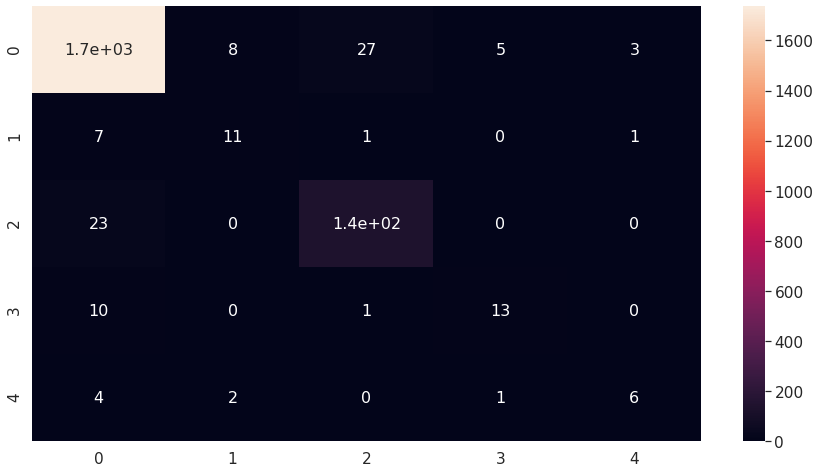

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(array, range(5), range(5))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [ ]:
train(data.train_dataloader, data.val_dataloader, model, 'tamil_mal.pt')